<a href="https://colab.research.google.com/github/NicolasDenier/Handwriting-recognition/blob/main/Handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 36.3 MB/s 


In [85]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling, Reshape, Dropout, RandomRotation, RandomZoom, GaussianNoise

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Metadata: label and path of each image
characters_data_url = "drive/My Drive/Colab Notebooks/OCR-data/characters/"
characters = pd.read_csv(characters_data_url + "english.csv")
characters.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


(900, 1200, 3)


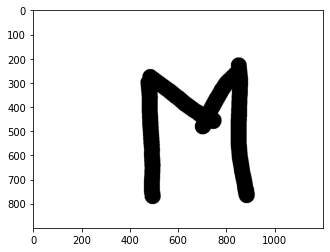

In [6]:
# Show a single image to have an idea of the data
img = image.imread(characters_data_url+characters['image'][1234])
print(img.shape)
plt.imshow(img)
plt.show()

In [7]:
# Number of images in a batch
batch_size = 32
# The desired image size
img_height = 180
img_width = 240

In [8]:
classes = characters['label'].unique() # list of classes
num_classes=len(characters['label'].unique()) # number of classes (10 diits + 26 lowercase + 26 uppercase = 62)
label_to_int = {classes[i]:i for i in range(num_classes)} # dict to get an unique id as int for each class
int_to_label = {value:key for key, value in label_to_int.items()} # dict to get back a string label from an int
labels = [label_to_int[l] for l in characters['label']] # list of labels as int

In [9]:
# Prepare the data stream batches (it avoids to overload the RAM)
train_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=10,
    validation_split = 0.2,
    shuffle=True,
    subset = "training"
    )

# For some reason the labels are definitely shuffled and need to be redefined
labels = [label_to_int[l] for l in characters['label']]

val_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=10,
    validation_split = 0.2,
    shuffle=True,
    subset = "validation"
    )

Found 3410 files belonging to 1 classes.
Using 2728 files for training.
Found 3410 files belonging to 1 classes.
Using 682 files for validation.


(32, 180, 240, 1)
(32,)


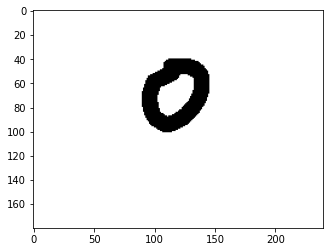

O


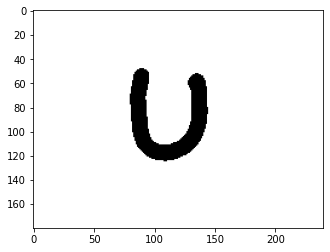

U


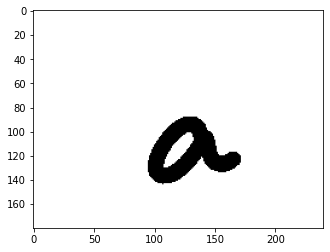

a


In [10]:
# Check that the labels are correct
for image, label in val_ds:
    print(image.shape)
    print(label.shape)
    for i in range(3):
      plt.imshow(np.reshape(image[i],(img_height, img_width)), cmap="gray")
      plt.show()
      print(int_to_label[label.numpy()[i]])
    break

In [11]:
# Better memory performances
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## First model

In [52]:
img_shape = (img_height, img_width, 1)

# define model
model1 = Sequential([
    Rescaling(1./255, input_shape=img_shape),
    Conv2D(16, padding='same', kernel_size=(3,3), activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [53]:
# compile
learning_rate = 1e-3
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [54]:
# fit
MODEL_NAME = 'base_model'
logs = {}
EPOCHS = 10
logs[MODEL_NAME] = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
86/86 [==============================] - 3s 29ms/step - loss: 3.9311 - accuracy: 0.0766 - val_loss: 3.2443 - val_accuracy: 0.2038
Epoch 2/10
86/86 [==============================] - 2s 27ms/step - loss: 2.2662 - accuracy: 0.4197 - val_loss: 2.2817 - val_accuracy: 0.4340
Epoch 3/10
86/86 [==============================] - 2s 28ms/step - loss: 1.0571 - accuracy: 0.7133 - val_loss: 2.1024 - val_accuracy: 0.5044
Epoch 4/10
86/86 [==============================] - 2s 27ms/step - loss: 0.4274 - accuracy: 0.8743 - val_loss: 2.4971 - val_accuracy: 0.5103
Epoch 5/10
86/86 [==============================] - 2s 27ms/step - loss: 0.1675 - accuracy: 0.9490 - val_loss: 3.0047 - val_accuracy: 0.4883
Epoch 6/10
86/86 [==============================] - 2s 27ms/step - loss: 0.1166 - accuracy: 0.9674 - val_loss: 3.1165 - val_accuracy: 0.5015
Epoch 7/10
86/86 [==============================] - 2s 27ms/step - loss: 0.0944 - accuracy: 0.9817 - val_loss: 3.0093 - val_accuracy: 0.5191
Epoch 8/10
86

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

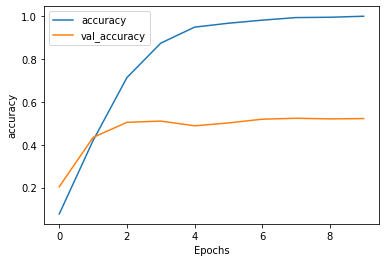

In [55]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

## More complex model
Addding 2 layers with more nodes, changing kernel size

In [58]:
model2 = Sequential([
    Rescaling(1./255, input_shape=img_shape),
    Conv2D(16, padding='same', kernel_size=(7,7), activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [59]:
# fit
MODEL_NAME = 'more_complex'

logs[MODEL_NAME] = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
86/86 [==============================] - 4s 35ms/step - loss: 4.0426 - accuracy: 0.0330 - val_loss: 3.5626 - val_accuracy: 0.1188
Epoch 2/10
86/86 [==============================] - 3s 33ms/step - loss: 2.6695 - accuracy: 0.3215 - val_loss: 2.0461 - val_accuracy: 0.4736
Epoch 3/10
86/86 [==============================] - 3s 33ms/step - loss: 1.3485 - accuracy: 0.6250 - val_loss: 1.4721 - val_accuracy: 0.6158
Epoch 4/10
86/86 [==============================] - 3s 33ms/step - loss: 0.7653 - accuracy: 0.7581 - val_loss: 1.2738 - val_accuracy: 0.6598
Epoch 5/10
86/86 [==============================] - 3s 34ms/step - loss: 0.4765 - accuracy: 0.8530 - val_loss: 1.2197 - val_accuracy: 0.6833
Epoch 6/10
86/86 [==============================] - 3s 34ms/step - loss: 0.3107 - accuracy: 0.8992 - val_loss: 1.5277 - val_accuracy: 0.6994
Epoch 7/10
86/86 [==============================] - 3s 34ms/step - loss: 0.1946 - accuracy: 0.9421 - val_loss: 1.4642 - val_accuracy: 0.7038
Epoch 8/10
86

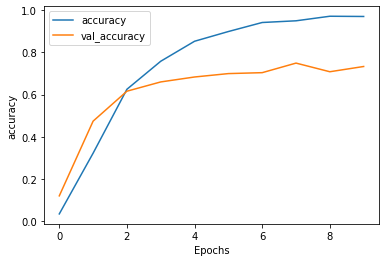

In [60]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

## Adding dropout
implies to train for more epochs to reach similar accuracy

In [108]:
model3 = Sequential([
    Rescaling(1./255, input_shape=img_shape),
    Conv2D(16, padding='same', kernel_size=(7,7), activation='relu'),
    Dropout(0.4),
    MaxPooling2D(padding='same'),
    Dropout(0.3),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    Dropout(0.4),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    Dropout(0.4),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [109]:
MODEL_NAME = 'dropout'
EPOCHS=20

logs[MODEL_NAME] = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/20
86/86 [==============================] - 5s 48ms/step - loss: 4.1472 - accuracy: 0.0147 - val_loss: 4.1281 - val_accuracy: 0.0132
Epoch 2/20
86/86 [==============================] - 4s 45ms/step - loss: 3.9107 - accuracy: 0.0594 - val_loss: 3.9648 - val_accuracy: 0.1012
Epoch 3/20
86/86 [==============================] - 4s 45ms/step - loss: 2.9485 - accuracy: 0.2302 - val_loss: 3.2466 - val_accuracy: 0.3065
Epoch 4/20
86/86 [==============================] - 4s 45ms/step - loss: 1.7444 - accuracy: 0.5029 - val_loss: 2.5845 - val_accuracy: 0.5000
Epoch 5/20
86/86 [==============================] - 4s 45ms/step - loss: 1.1915 - accuracy: 0.6591 - val_loss: 2.1402 - val_accuracy: 0.6290
Epoch 6/20
86/86 [==============================] - 4s 45ms/step - loss: 0.8235 - accuracy: 0.7482 - val_loss: 1.7459 - val_accuracy: 0.6730
Epoch 7/20
86/86 [==============================] - 4s 44ms/step - loss: 0.6169 - accuracy: 0.8039 - val_loss: 1.7068 - val_accuracy: 0.6979
Epoch 8/20
86

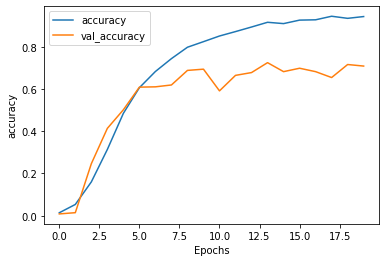

In [107]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

## Data augmentation

In [76]:
data_augmentation = Sequential(
  [
    GaussianNoise(0.2),
    RandomRotation((-0.1, 0.1)),
    RandomZoom(0.1, 0.1),
  ]
)

model4 = Sequential([
    data_augmentation,
    tf.keras.models.clone_model(model3)
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )


In [77]:
MODEL_NAME = 'data_augmentation'

logs[MODEL_NAME] = model4.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/20
86/86 [==============================] - 5s 48ms/step - loss: 4.1457 - accuracy: 0.0161 - val_loss: 4.1285 - val_accuracy: 0.0073
Epoch 2/20
86/86 [==============================] - 4s 46ms/step - loss: 4.0786 - accuracy: 0.0319 - val_loss: 3.9982 - val_accuracy: 0.0762
Epoch 3/20
86/86 [==============================] - 4s 47ms/step - loss: 3.5634 - accuracy: 0.1059 - val_loss: 3.6781 - val_accuracy: 0.1994
Epoch 4/20
86/86 [==============================] - 4s 46ms/step - loss: 2.9012 - accuracy: 0.2298 - val_loss: 3.0191 - val_accuracy: 0.4150
Epoch 5/20
86/86 [==============================] - 4s 46ms/step - loss: 2.2219 - accuracy: 0.3985 - val_loss: 2.7512 - val_accuracy: 0.5147
Epoch 6/20
86/86 [==============================] - 4s 46ms/step - loss: 1.6629 - accuracy: 0.5315 - val_loss: 2.2431 - val_accuracy: 0.5924
Epoch 7/20
86/86 [==============================] - 4s 46ms/step - loss: 1.3310 - accuracy: 0.6169 - val_loss: 2.0419 - val_accuracy: 0.6378
Epoch 8/20
86

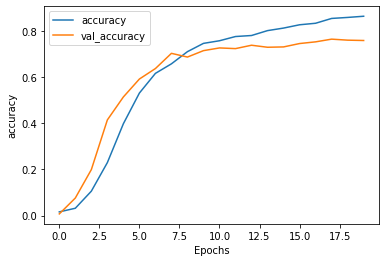

In [78]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

## Adjusting learning rate 
adding callbacks to adjust learning rate and do early stopping

In [110]:
# early stopping
cb_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# learning rate scheduler
def scheduler(epoch, lr):
  #if epoch <8:
  #  if epoch <4:
  #    return lr/ tf.math.exp(-0.01*epoch)
  #  return lr* tf.math.exp(-0.01*epoch)

  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.01*epoch)

cb_LRScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [111]:
model5=tf.keras.models.clone_model(model4)
MODEL_NAME = 'adjusted_learning_rate'

model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

EPOCHS=30

logs[MODEL_NAME] = model5.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks=[cb_EarlyStopping, cb_LRScheduler]
)

Epoch 1/30
86/86 [==============================] - 5s 48ms/step - loss: 4.1524 - accuracy: 0.0103 - val_loss: 4.1282 - val_accuracy: 0.0103 - lr: 0.0010
Epoch 2/30
86/86 [==============================] - 4s 46ms/step - loss: 4.1269 - accuracy: 0.0161 - val_loss: 4.1269 - val_accuracy: 0.0205 - lr: 0.0010
Epoch 3/30
86/86 [==============================] - 4s 47ms/step - loss: 3.8721 - accuracy: 0.0462 - val_loss: 3.8498 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 4/30
86/86 [==============================] - 4s 47ms/step - loss: 3.2484 - accuracy: 0.1631 - val_loss: 3.3232 - val_accuracy: 0.3123 - lr: 0.0010
Epoch 5/30
86/86 [==============================] - 4s 47ms/step - loss: 2.5003 - accuracy: 0.3266 - val_loss: 2.9944 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 6/30
86/86 [==============================] - 4s 46ms/step - loss: 1.8547 - accuracy: 0.4828 - val_loss: 2.4084 - val_accuracy: 0.5704 - lr: 0.0010
Epoch 7/30
86/86 [==============================] - 4s 46ms/step - loss: 1.4

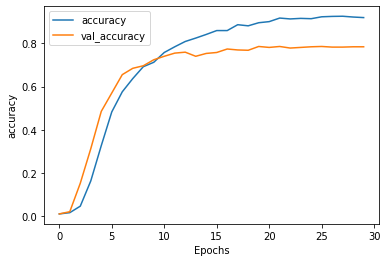

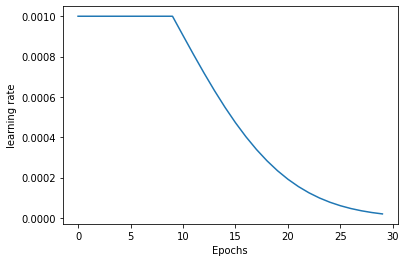

In [112]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

plt.plot(logs[MODEL_NAME].history['lr'])
plt.xlabel("Epochs")
plt.ylabel('learning rate')
plt.show()

In [115]:
!

fatal: not a git repository (or any of the parent directories): .git
